In [1]:
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from cosmo_numba.B_modes.schneider2022 import get_pure_EB_modes, get_CNPT_EB_modes

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10

mpl.rcParams['font.size'] = 20

mpl.rcParams['xtick.minor.size'] = 7
mpl.rcParams['ytick.minor.size'] = 7

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3


mpl.rcParams['axes.xmargin'] = mpl.rcParamsDefault['axes.xmargin']

color = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Cosmo model

In [4]:
def get_model(
    theta,
    z,
    nz,
    Omega_c,
    h,
    Omega_b,
    sig8,
    ns,
    B_amp,
    b_ia,
):

    theta_deg = theta/60

    cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        h=h,
        n_s=ns,
        sigma8=sig8,

        transfer_function='boltzmann_camb',
        matter_power_spectrum='camb',
        extra_parameters={
            "camb": {
                "halofit_version": 'mead2016',  # 'mead2020',
                "HMCode_A_baryon": B_amp,
                "kmax": 21,
                # We do this to avoid warnings in CAMB with (kmax < 5 or
                # 'kmax < 20 and z > 4') (set internally in ccl)
                # default: kmax=10
            }
        }
    )
    ccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = True

    lens = ccl.WeakLensingTracer(
        cosmo,
        dndz=(z, nz),
        ia_bias=(z, np.ones_like(z)*b_ia),
        use_A_ia=True,
    )

    l_min = 1
    l_max = 60_000
    l_bin = 1_000
    ell = np.logspace(np.log10(l_min), np.log10(l_max), l_bin)
    cl = ccl.angular_cl(cosmo, lens, lens, ell)

    xip_fit = ccl.correlation(
        cosmo,
        ell=ell,
        C_ell=cl,
        theta=theta_deg,
        type='GG+',
        method='fftlog',
    )
    xim_fit = ccl.correlation(
        cosmo,
        ell=ell,
        C_ell=cl,
        theta=theta_deg,
        type='GG-',
        method='fftlog'
    )

    #xi = np.concatenate((xip_fit, xim_fit))

    return xip_fit, xim_fit

In [5]:
def dist_nz(z, c_z):
    """
    eq 13 in https://iopscience.iop.org/article/10.3847/1538-4357/ac062f/pdf
    """
    return 0.5/c_z * (z/c_z)**2 * np.exp(-z/c_z)

## Set parameters

In [6]:
# Thin bins
tmin_int = 0.2
tmax_int = 500
bin_size_int = 0.02
#nbins_int = int((np.log(tmax_int) - np.log(tmin_int))/bin_size_int)
nbins_int = 2_000
print("nbins int:", nbins_int)

tmin = 0.5
tmax = 250
bin_size = 0.3
nbins = int((np.log(tmax) - np.log(tmin))/bin_size)
print("nbins:", nbins)

nbins int: 2000
nbins: 20


In [7]:
# Planck cosmo 2018 | TT,TE,EE+lowE+lensing+BAO
h = 0.6766
Om = 0.3111
Ov = 0.6889
sig8 = 0.8102
ns = 0.9665
Ob_h2 = 0.02242
Ob = Ob_h2/h**2
Oc_h2 = 0.11933
Oc = Oc_h2/h**2
b_ia = 0.5
B_amp = 3.13

area = 1442.3673153360855
shape_noise = 0.30130993906642944
n_eff = 6.727816168552552
z = np.linspace(0, 3, 256)
c_z = 0.24
nz = dist_nz(z, c_z)

## Get pure B-modes

In [8]:
theta_ = np.logspace(np.log10(tmin), np.log10(tmax), nbins+1)
theta = np.mean([theta_[:-1], theta_[1:]], axis=0)
theta_int_ = np.logspace(np.log10(tmin_int), np.log10(tmax_int), nbins_int+1)
theta_int = np.mean([theta_int_[:-1], theta_int_[1:]], axis=0)

In [9]:
xip_model_int, xim_model_int = get_model(
    theta_int,
    z,
    nz,
    Oc,
    h,
    Ob,
    sig8,
    ns,
    B_amp,
    b_ia,
)

In [10]:
xip_model, xim_model = get_model(
    theta,
    z,
    nz,
    Oc,
    h,
    Ob,
    sig8,
    ns,
    B_amp,
    b_ia,
)

In [11]:
xip_E_model, xim_E_model, xip_B_model, xim_B_model, xip_amb_model, xim_amb_model = get_pure_EB_modes(
    theta, xip_model, xim_model, theta_int, xip_model_int, xim_model_int, tmin, tmax,
)

Text(0.5, 0.98, 'Pure E/B-modes')

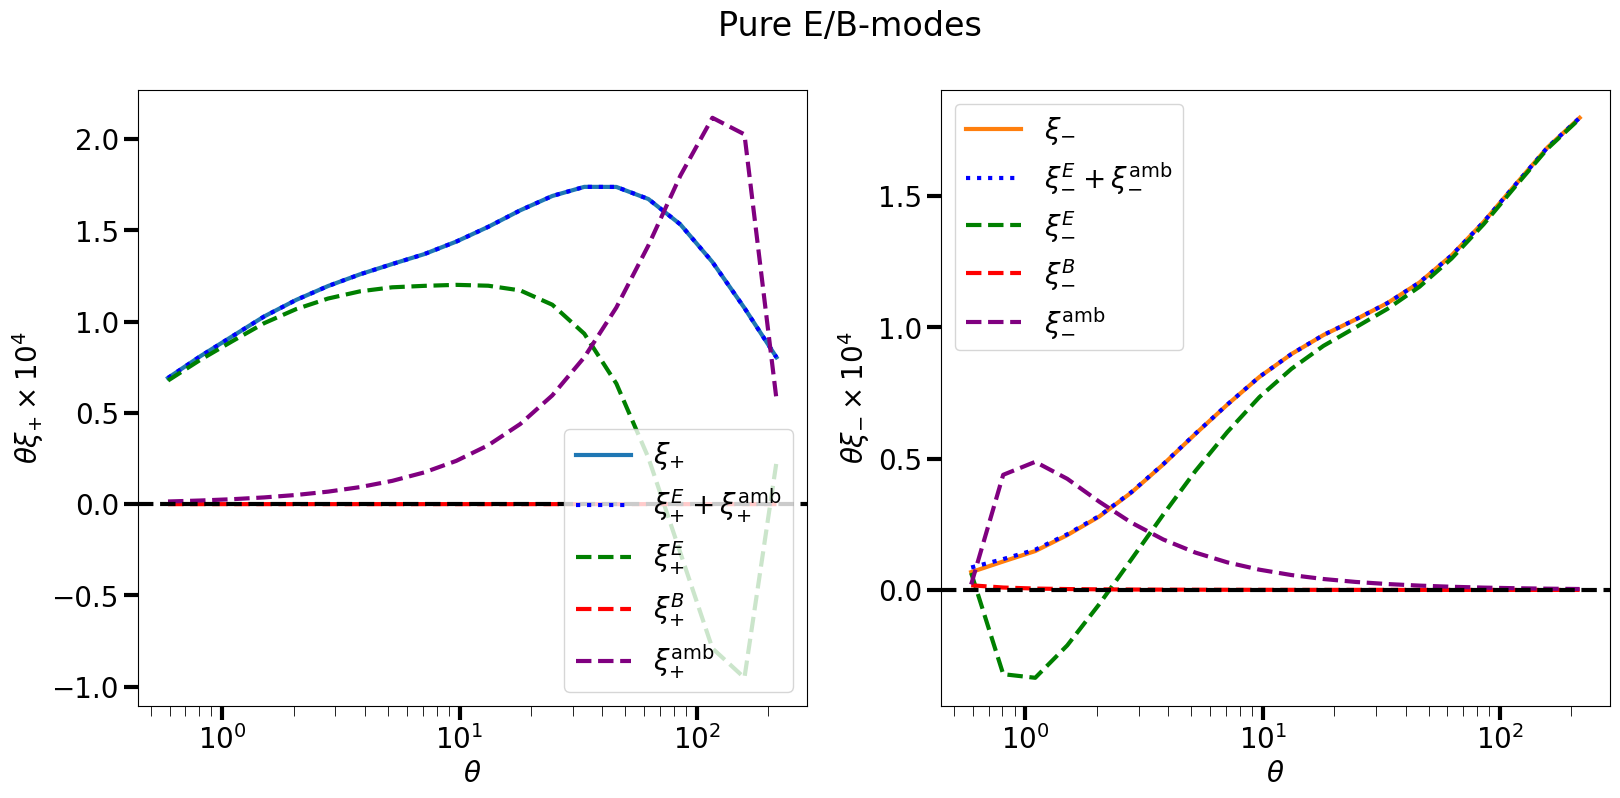

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(19, 8))
axs[0].plot(theta, theta*xip_model/1e-4, color=color[0], label=r"$\xi_{+}$")
axs[0].plot(theta, theta*(xip_E_model+xip_amb_model)/1e-4, 'b:', label=r"$\xi_{+}^{E}+\xi_{+}^{\mathrm{amb}}$")
axs[0].plot(theta, theta*xip_E_model/1e-4, 'g--', label=r"$\xi_{+}^{E}$")
axs[0].plot(theta, theta*xip_B_model/1e-4, 'r--', label=r"$\xi_{+}^{B}$")
axs[0].plot(theta, theta*xip_amb_model/1e-4, '--', color='purple', label=r"$\xi_{+}^{\mathrm{amb}}$")
axs[0].axhline(0, ls='--', color='k')
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"$\theta\xi_{+}\times10^{4}$")
axs[0].legend()

axs[1].plot(theta, theta*xim_model/1e-4, color=color[1], label=r"$\xi_{-}$")
axs[1].plot(theta, theta*(xim_E_model+xim_amb_model)/1e-4, 'b:', label=r"$\xi_{-}^{E}+\xi_{-}^{\mathrm{amb}}$")
axs[1].plot(theta, theta*xim_E_model/1e-4, 'g--', label=r"$\xi_{-}^{E}$")
axs[1].plot(theta, theta*xim_B_model/1e-4, 'r--', label=r"$\xi_{-}^{B}$")
axs[1].plot(theta, theta*xim_amb_model/1e-4, '--', color='purple', label=r"$\xi_{-}^{\mathrm{amb}}$")
axs[1].axhline(0, ls='--', color='k')
axs[1].set_xscale('log')
axs[1].set_xlabel(r"$\theta$")
axs[1].set_ylabel(r"$\theta\xi_{-}\times10^{4}$")
axs[1].legend()
fig.suptitle("Pure E/B-modes")

Text(0.5, 0.98, 'Pure E/B-modes error')

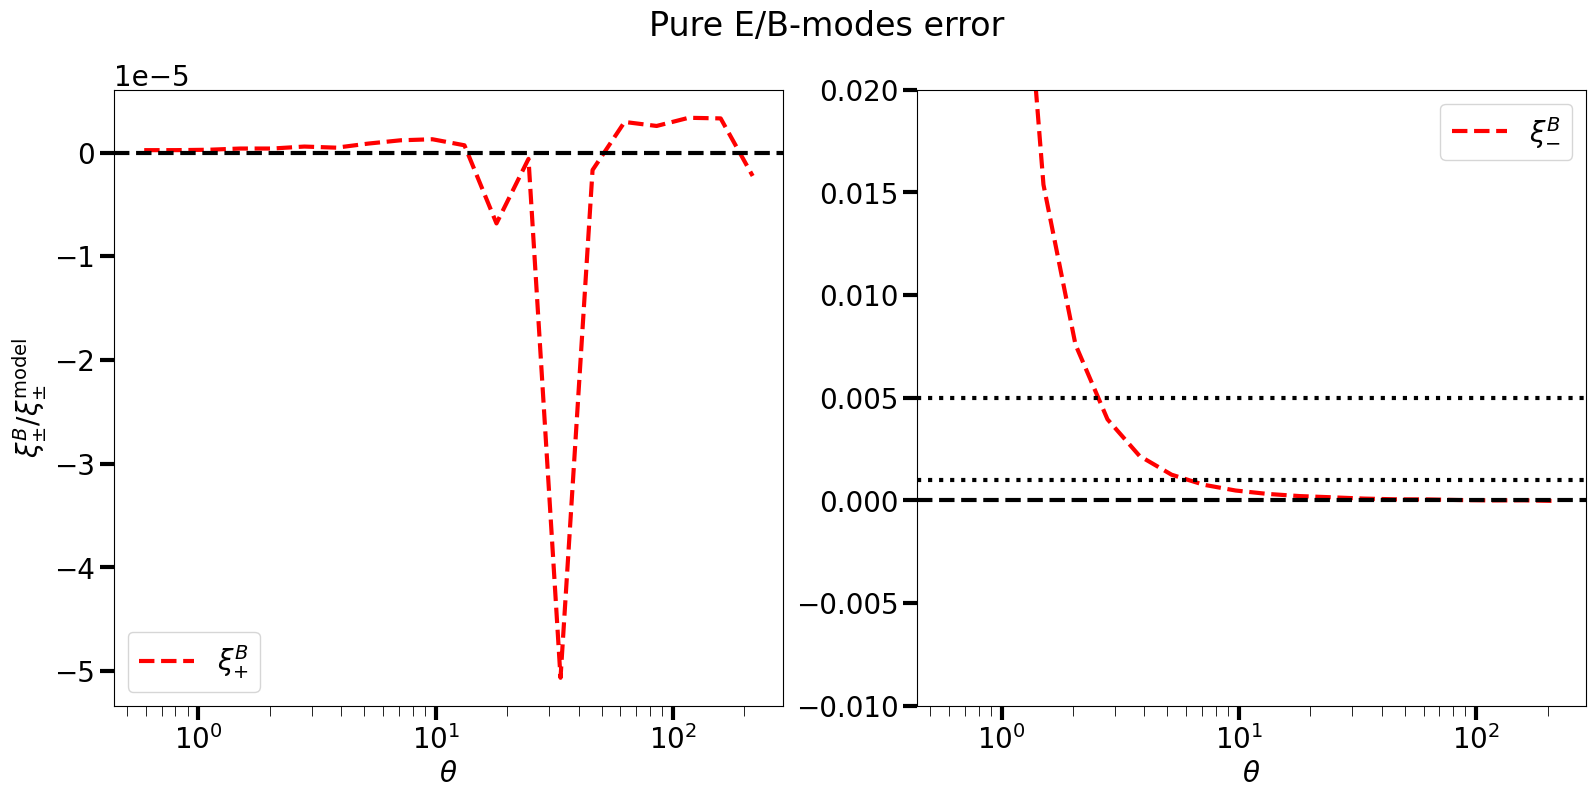

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(19, 8))
axs[0].plot(theta, xip_B_model/xip_model, 'r--', label=r"$\xi_{+}^{B}$")


axs[0].axhline(0, ls='--', color='k')
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"$\xi_{\pm}^{B}/\xi_{\pm}^{\rm{model}}$")
axs[0].legend()

axs[1].plot(theta, xim_B_model/xim_model, 'r--', label=r"$\xi_{-}^{B}$")
axs[1].axhline(0, ls='--', color='k')
axs[1].axhline(0.005, ls=':', color='k')
axs[1].axhline(0.001, ls=':', color='k')
axs[1].set_xscale('log')
axs[1].set_xlabel(r"$\theta$")
#axs[1].set_ylabel(r"$\theta\xi_{-}\times10^{4}$")
axs[1].set_ylim(-0.01, 0.02)
axs[1].legend()
fig.suptitle("Pure E/B-modes error")

## Get CNPT B-modes

In [14]:
xip_CNPT_E_model, xim_CNPT_E_model, xip_CNPT_B_model, xim_CNPT_B_model = get_CNPT_EB_modes(
    theta, xip_model, xim_model, theta_int, xip_model_int, xim_model_int, 0., 300,
)

Text(0.5, 0.98, 'CNPT E/B-modes')

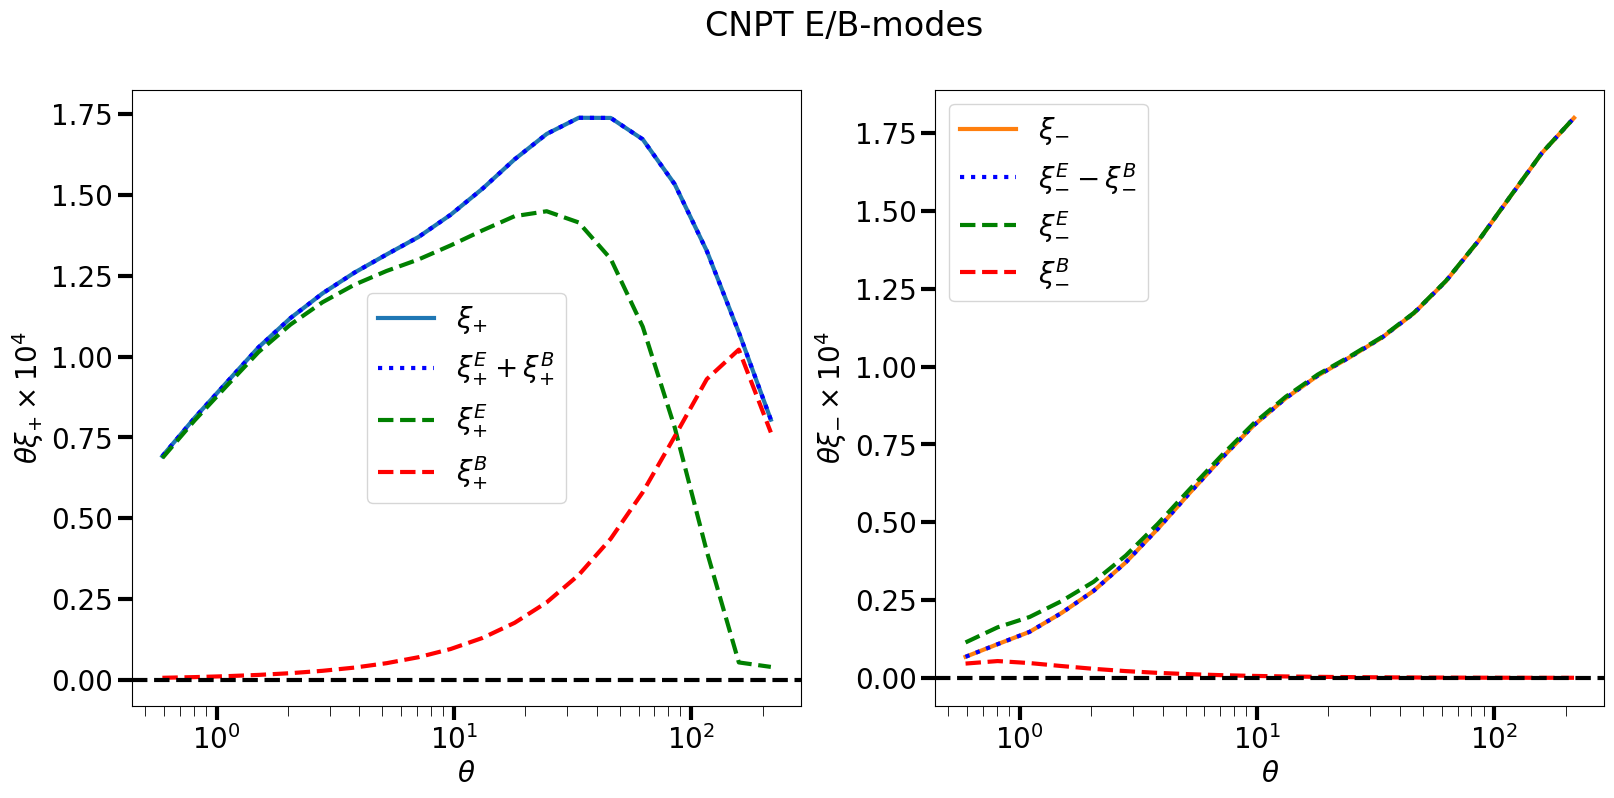

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(19, 8))
axs[0].plot(theta, theta*xip_model/1e-4, color=color[0], label=r"$\xi_{+}$")
axs[0].plot(theta, theta*(xip_CNPT_E_model+xip_CNPT_B_model)/1e-4, 'b:', label=r"$\xi_{+}^{E}+\xi_{+}^{B}$")
axs[0].plot(theta, theta*xip_CNPT_E_model/1e-4, 'g--', label=r"$\xi_{+}^{E}$")
axs[0].plot(theta, theta*xip_CNPT_B_model/1e-4, 'r--', label=r"$\xi_{+}^{B}$")
axs[0].axhline(0, ls='--', color='k')
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"$\theta\xi_{+}\times10^{4}$")
axs[0].legend()

axs[1].plot(theta, theta*xim_model/1e-4, color=color[1], label=r"$\xi_{-}$")
axs[1].plot(theta, theta*(xim_CNPT_E_model-xim_CNPT_B_model)/1e-4, 'b:', label=r"$\xi_{-}^{E}-\xi_{-}^{B}$")
axs[1].plot(theta, theta*xim_CNPT_E_model/1e-4, 'g--', label=r"$\xi_{-}^{E}$")
axs[1].plot(theta, theta*xim_CNPT_B_model/1e-4, 'r--', label=r"$\xi_{-}^{B}$")
axs[1].axhline(0, ls='--', color='k')
axs[1].set_xscale('log')
axs[1].set_xlabel(r"$\theta$")
axs[1].set_ylabel(r"$\theta\xi_{-}\times10^{4}$")
axs[1].legend()
fig.suptitle("CNPT E/B-modes")

Text(0.5, 0.98, 'CNPT E/B-modes error')

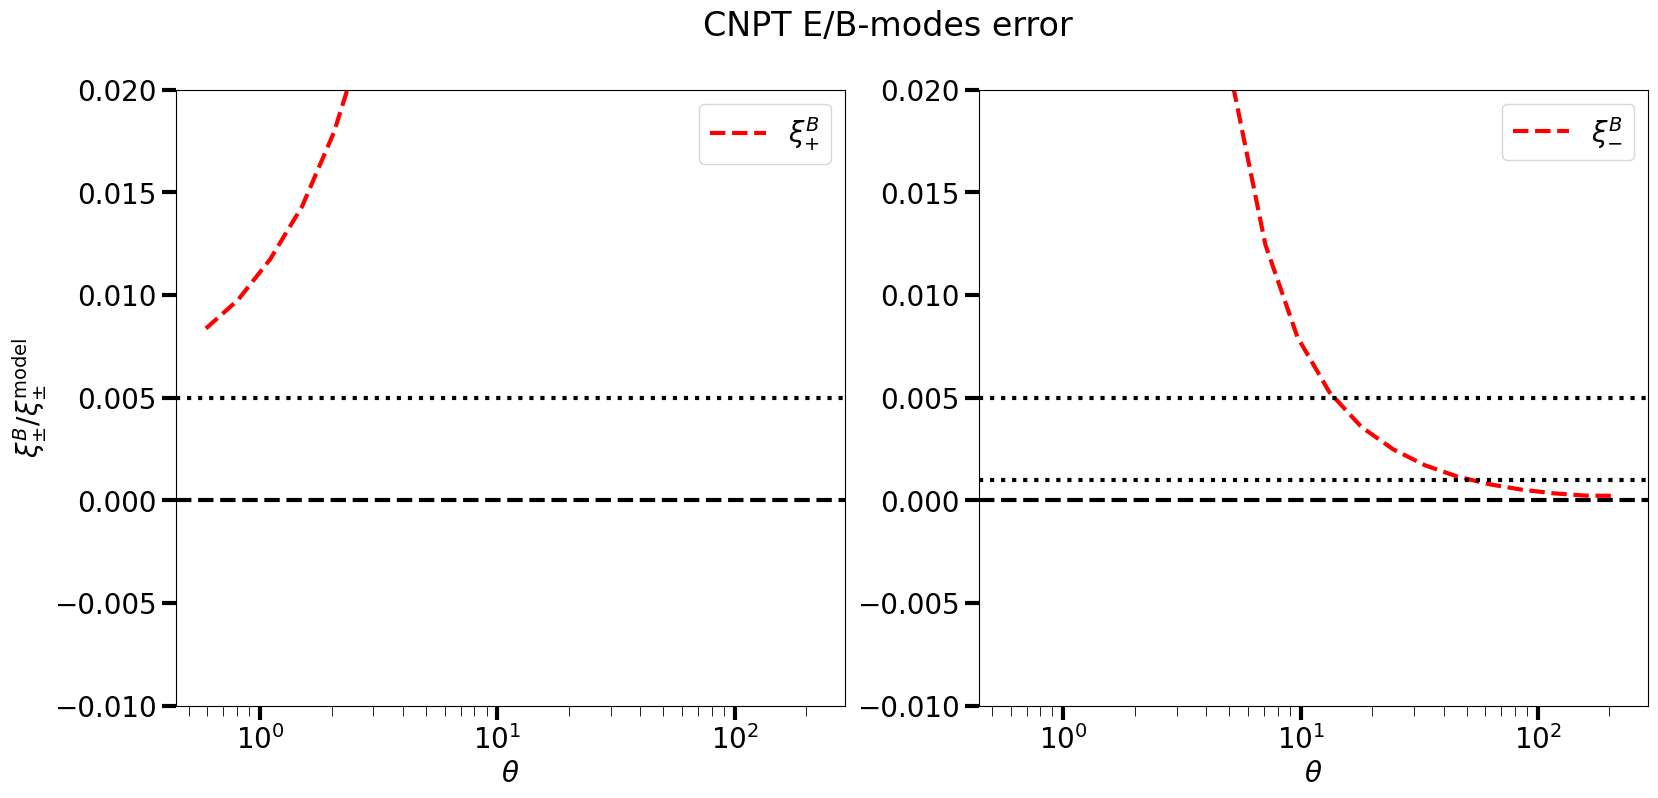

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(19, 8))

axs[0].plot(theta, xip_CNPT_B_model/xip_model, 'r--', label=r"$\xi_{+}^{B}$")
axs[0].axhline(0, ls='--', color='k')
axs[0].axhline(0.005, ls=':', color='k')
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"$\xi_{\pm}^{B}/\xi_{\pm}^{\rm{model}}$")
axs[0].set_ylim(-0.01, 0.02)
axs[0].legend()

axs[1].plot(theta, xim_CNPT_B_model/xim_model, 'r--', label=r"$\xi_{-}^{B}$")
axs[1].axhline(0, ls='--', color='k')
axs[1].axhline(0.005, ls=':', color='k')
axs[1].axhline(0.001, ls=':', color='k')
axs[1].set_xscale('log')
axs[1].set_xlabel(r"$\theta$")
#axs[1].set_ylabel(r"$\xi_{-}^{B}/\xi_{-}^{\rm{model}}$")
axs[1].set_ylim(-0.01, 0.02)
axs[1].legend()
fig.suptitle("CNPT E/B-modes error")